In [1]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42   # embed TrueType (selectable/copyable)
mpl.rcParams['ps.fonttype']  = 42   # same for .ps if you ever use it
mpl.rcParams['text.usetex']  = False  # unless you’re using the PGF route below
# optional: pick a common TTF so it embeds cleanly
mpl.rcParams['font.family'] = 'DejaVu Sans'

import matplotlib.pyplot as plt

import numpy as np
from numpy import random
import os
from ctd.comparison.analysis.tt.tt import Analysis_TT 
from ctd.comparison.analysis.dd.dd import Analysis_DD
# Import pca
import dotenv
from ctd.comparison.comparison import Comparison
import torch
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import math
import torch.nn.functional as F
dotenv.load_dotenv(dotenv.find_dotenv())
torch.manual_seed(42)
np.random.seed(42)


In [2]:


HOME_DIR = os.environ['HOME_DIR']
print(HOME_DIR)

pathTT = HOME_DIR + 'content/trained_models/task-trained/tt_3bff/'
an_TT = Analysis_TT(run_name = "TT", filepath = pathTT)


path_NODE_Sweep = pathTT + "20250207_3BFF_NODE_sweep/"
subfolders_NODE = [f.path for f in os.scandir(path_NODE_Sweep) if f.is_dir()]


/home/csverst/Github/CtDBenchmark/


In [3]:
lex_TT_mean, lex_TT_std = an_TT.compute_lyapunov_exp(phase ="val")
print(f" Lyapunov exponent mean: {lex_TT_mean}, std: {lex_TT_std}")

 Lyapunov exponent mean: tensor([-0.0230, -0.0294, -0.0360, -0.0425, -0.0478, -0.0533, -0.0591, -0.0660,
        -0.0767, -0.0855, -0.1011, -0.1326, -0.1663, -0.1987, -0.2367, -0.2934,
        -0.3576, -0.4234, -0.5105, -0.5792, -0.6420, -0.6961, -0.7607, -0.8271,
        -0.8792, -0.9294, -0.9927, -1.0543, -1.1128, -1.1692, -1.2189, -1.2727,
        -1.3265, -1.3751, -1.4154, -1.4661, -1.4983, -1.5413, -1.5813, -1.6137,
        -1.6514, -1.7029, -1.7392, -1.7885, -1.8265, -1.8825, -1.9249, -1.9763,
        -2.0116, -2.0684, -2.1206, -2.1693, -2.2327, -2.2924, -2.3529, -2.4323,
        -2.5088, -2.5959, -2.7048, -2.8318, -2.9954, -3.2083, -3.5720, -4.3490],
       grad_fn=<MeanBackward1>), std: tensor([0.0051, 0.0057, 0.0059, 0.0063, 0.0064, 0.0069, 0.0079, 0.0091, 0.0103,
        0.0121, 0.0148, 0.0220, 0.0302, 0.0411, 0.0430, 0.0453, 0.0481, 0.0510,
        0.0447, 0.0354, 0.0301, 0.0321, 0.0318, 0.0347, 0.0374, 0.0385, 0.0422,
        0.0477, 0.0529, 0.0638, 0.0664, 0.0687, 0.0729, 

In [4]:
comparison = Comparison(comparison_tag="Figure1NBFF_TTGRU_Sweep")
comparison.load_analysis(an_TT, reference_analysis=True, group = "TT")

for subfolder in subfolders_NODE:
    subfolder = subfolder + "/"
    # Find int eh subfolder where latent_size is, and get the value after the = sign
    # split the subfolder name
    latent_size = subfolder.split("latent_size=")[1].split("_")[0]
    # Make string with no decimals
    
    analysis_NODE = Analysis_DD.create(run_name = f"NODE{latent_size}", filepath = subfolder, model_type = "SAE")
    comparison.load_analysis(analysis_NODE, group = f"NODE{latent_size}")

comparison.regroup()

In [5]:
metric_dict_list = {
    'state_r2': {},
    'rate_r2': {},
    'cycle_con': {'variance_threshold': 0.01},
    'co-bps': {},
    'mmd': {'feature_types': ['pairwise', 'distances'],
            "max_pairwise_samples": 10000},
    'lyapunov': {},
    'nl_cycle_con': {'max_epochs': 1000, 'noise_stds': [0, 0.01, 0.05, 0.1, 0.25, 0.5]},
}
metrics = comparison.compute_metrics(metric_dict_list=metric_dict_list)



Working on 1 of 31: NODE16
State R2: 0.782531201839447
Rate R2: 0.9133732318878174
Cycle Consistency R2: 0.7750168442726135
CO-BPS: 0.12677448987960815
  pairwise MMD: 0.090656
  distances MMD: 0.021216
MMD: 0.05593612219482522
Lyapunov Exponent: -0.001328 +/- 0.000078
Epoch 1000/1000...  Noise std 0.000 -> val R^2 0.9616
  Noise std 0.010 -> val R^2 0.9572
  Noise std 0.050 -> val R^2 0.8520
  Noise std 0.100 -> val R^2 0.5372
  Noise std 0.250 -> val R^2 -1.1748
  Noise std 0.500 -> val R^2 -5.3912
Nonlinear Cycle Consistency R2: {'val_r2': 0.9616478681564331, 'noise_stds': [0, 0.01, 0.05, 0.1, 0.25, 0.5], 'r2_per_noise': [0.9616478681564331, 0.9572336077690125, 0.8519843816757202, 0.5371793508529663, -1.1747804880142212, -5.39117431640625], 'enc_state_dict': {'net.0.weight': tensor([[ 0.0833,  0.1061, -0.0518,  ..., -0.0100, -0.0830,  0.0191],
        [ 0.0937,  0.0766, -0.2083,  ..., -0.0811,  0.0580, -0.1161],
        [ 0.0655, -0.0405, -0.0638,  ..., -0.0862,  0.0673, -0.1211],


In [6]:
# Sort the metrics list by the latent size
import re

def sort_metrics_by_latent(metrics_dict):
    """
    Sorts the metrics dictionary by latent size extracted from run_name entries.

    Parameters
    ----------
    metrics_dict : dict
        Dictionary with keys = metric names (including 'run_name').
        Each value is a list of results of equal length.
        'run_name' values must be strings of the form 'NODEX' where X is an int.

    Returns
    -------
    sorted_dict : dict
        New dict with the same keys, but each list is reordered by latent size.
    """
    run_names = metrics_dict["run_name"]

    # extract latent size integer from each run_name string
    latent_sizes = [int(re.search(r"NODE(\d+)", name).group(1)) for name in run_names]

    # get sorted indices
    sorted_idx = sorted(range(len(latent_sizes)), key=lambda i: latent_sizes[i])

    # build new dictionary with lists sorted by those indices
    sorted_dict = {
        key: [values[i] for i in sorted_idx]
        for key, values in metrics_dict.items()
    }

    return sorted_dict

metrics_s = sort_metrics_by_latent(metrics)

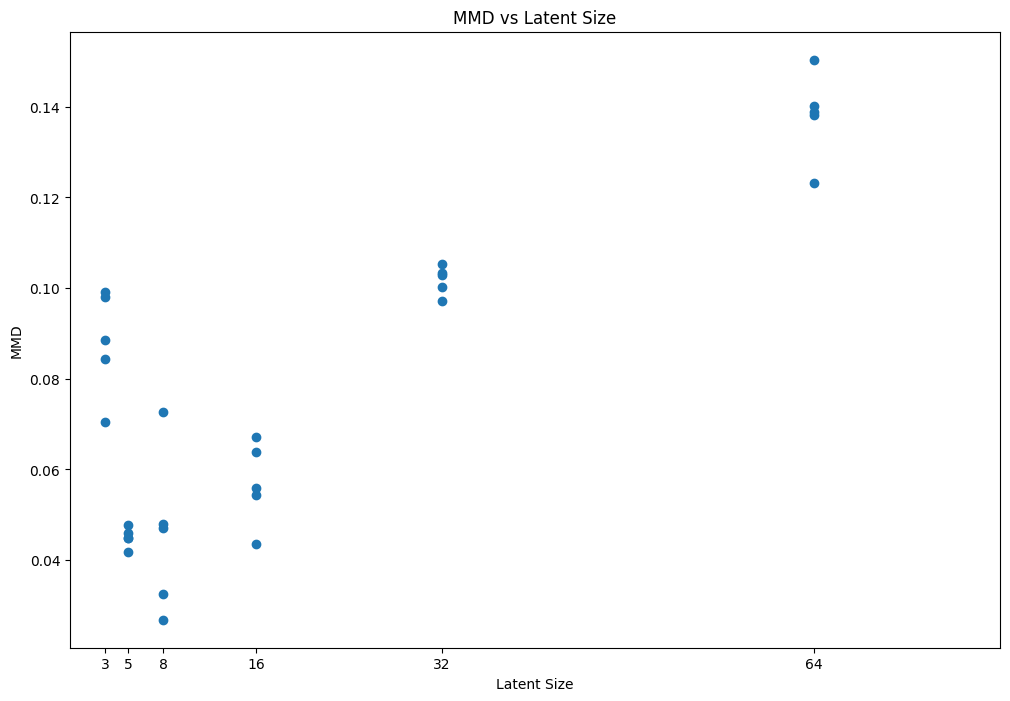

In [7]:
lat_size = []
groups = metrics_s['group']

for group in groups:
    lat_size.append(int(group.split("NODE")[1].split("_")[0]))

u_lat_size, idx = np.unique(lat_size, return_index=True)
u_lat_size = u_lat_size[np.argsort(idx)]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(lat_size, metrics_s['mmd'], )
ax.set_xlabel("Latent Size")
ax.set_ylabel("MMD")
ax.set_xlim([0, 80])
ax.set_title("MMD vs Latent Size")
ax.set_xticks(u_lat_size)

['NODE3', 'NODE3', 'NODE3', 'NODE3', 'NODE3', 'NODE5', 'NODE5', 'NODE5', 'NODE5', 'NODE5', 'NODE8', 'NODE8', 'NODE8', 'NODE8', 'NODE8', 'NODE16', 'NODE16', 'NODE16', 'NODE16', 'NODE16', 'NODE32', 'NODE32', 'NODE32', 'NODE32', 'NODE32', 'NODE64', 'NODE64', 'NODE64', 'NODE64', 'NODE64']
['NODE3' 'NODE5' 'NODE8' 'NODE16' 'NODE32' 'NODE64']


/tmp/ipykernel_2589479/500633633.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=colors1[np.where(unique_groups == legend_group)[0][0]], label=legend_group)
/tmp/ipykernel_2589479/500633633.py:38: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=colors1[np.where(unique_groups == legend_group)[0][0]], label=legend_group)


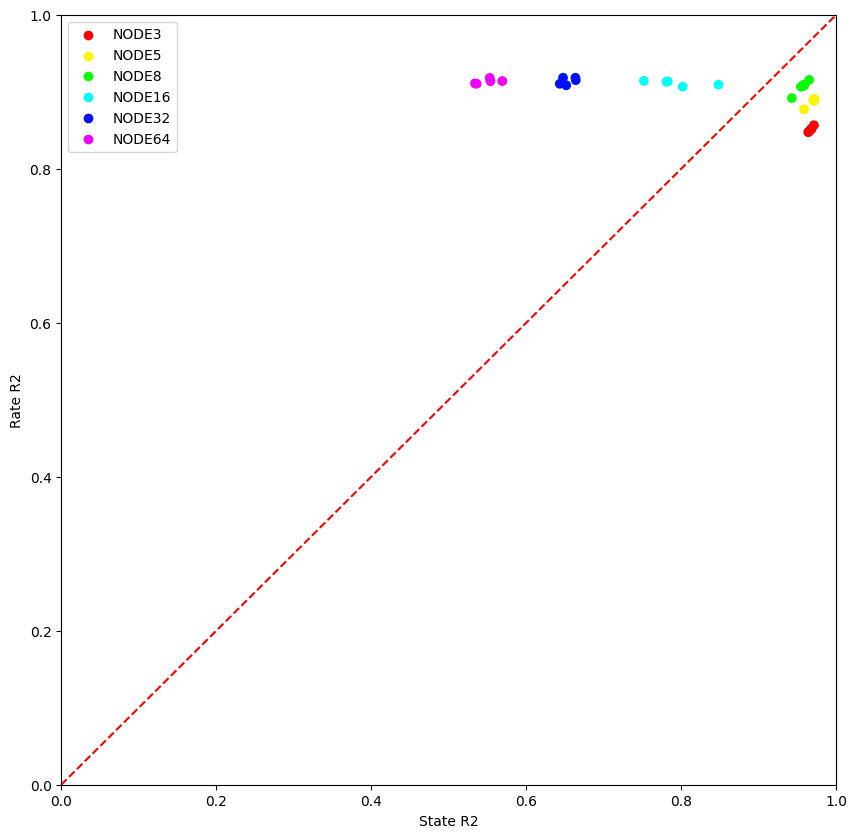

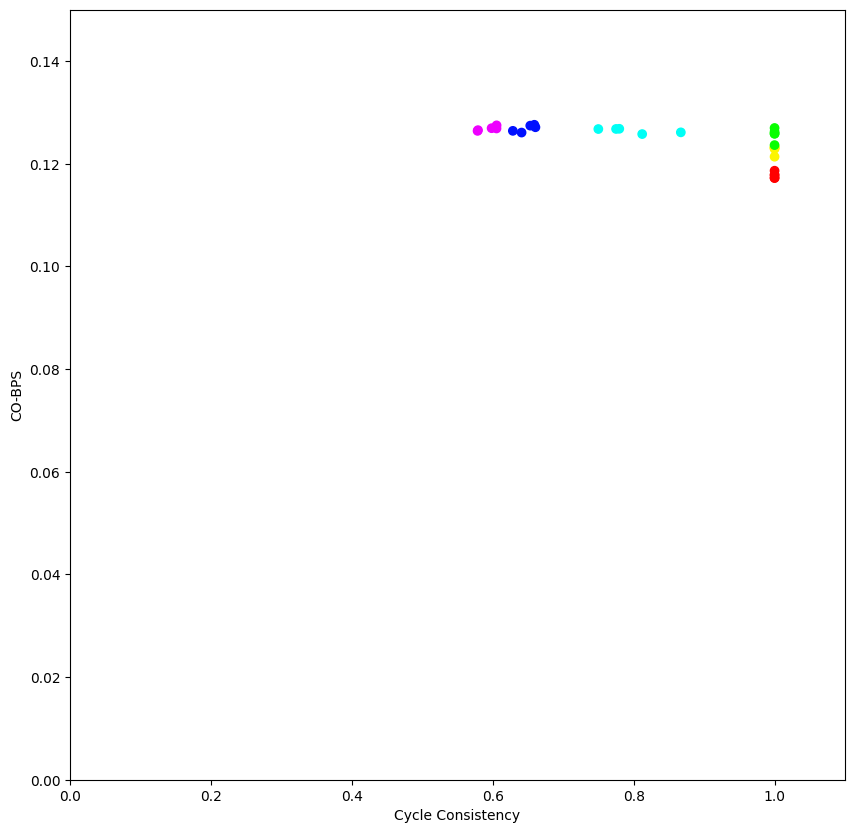

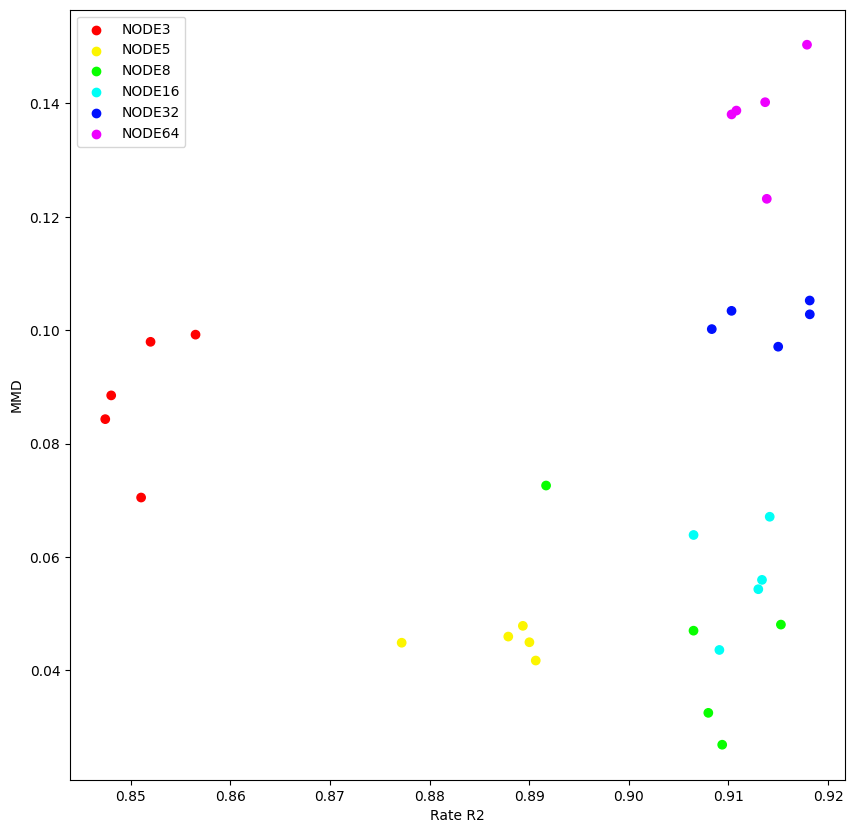

In [8]:
groups = metrics_s['group']
unique_groups, idx = np.unique(groups, return_index=True)
unique_groups = unique_groups[np.argsort(idx)]
print(groups)
print(unique_groups)
# group_indices = [np.where(groups == group)[0] for group in unique_groups]
colors1 = plt.cm.hsv(np.linspace(0, 1, len(unique_groups)+1))
colors_list = []
for i, group in enumerate(groups):
    colors_list.append(colors1[np.where(unique_groups == group)[0][0]])
    
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(metrics_s['state_r2'], metrics_s['rate_r2'], c = colors_list)
ax.set_xlabel("State R2")
ax.set_ylabel("Rate R2")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot([0, 1], [0, 1], 'r--')
for legend_group in unique_groups:
    ax.scatter([], [], c=colors1[np.where(unique_groups == legend_group)[0][0]], label=legend_group)
ax.legend()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(metrics_s['cycle_con'], metrics_s['co-bps'], c = colors_list)
ax.set_xlabel("Cycle Consistency")
ax.set_ylabel("CO-BPS")
ax.set_xlim([0, 1.1])
ax.set_ylim([0, 0.15])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(metrics_s['rate_r2'], metrics_s['mmd'], c = colors_list)
ax.set_xlabel("Rate R2")
ax.set_ylabel("MMD")
for legend_group in unique_groups:
    ax.scatter([], [], c=colors1[np.where(unique_groups == legend_group)[0][0]], label=legend_group)
ax.legend()
ax.legend()



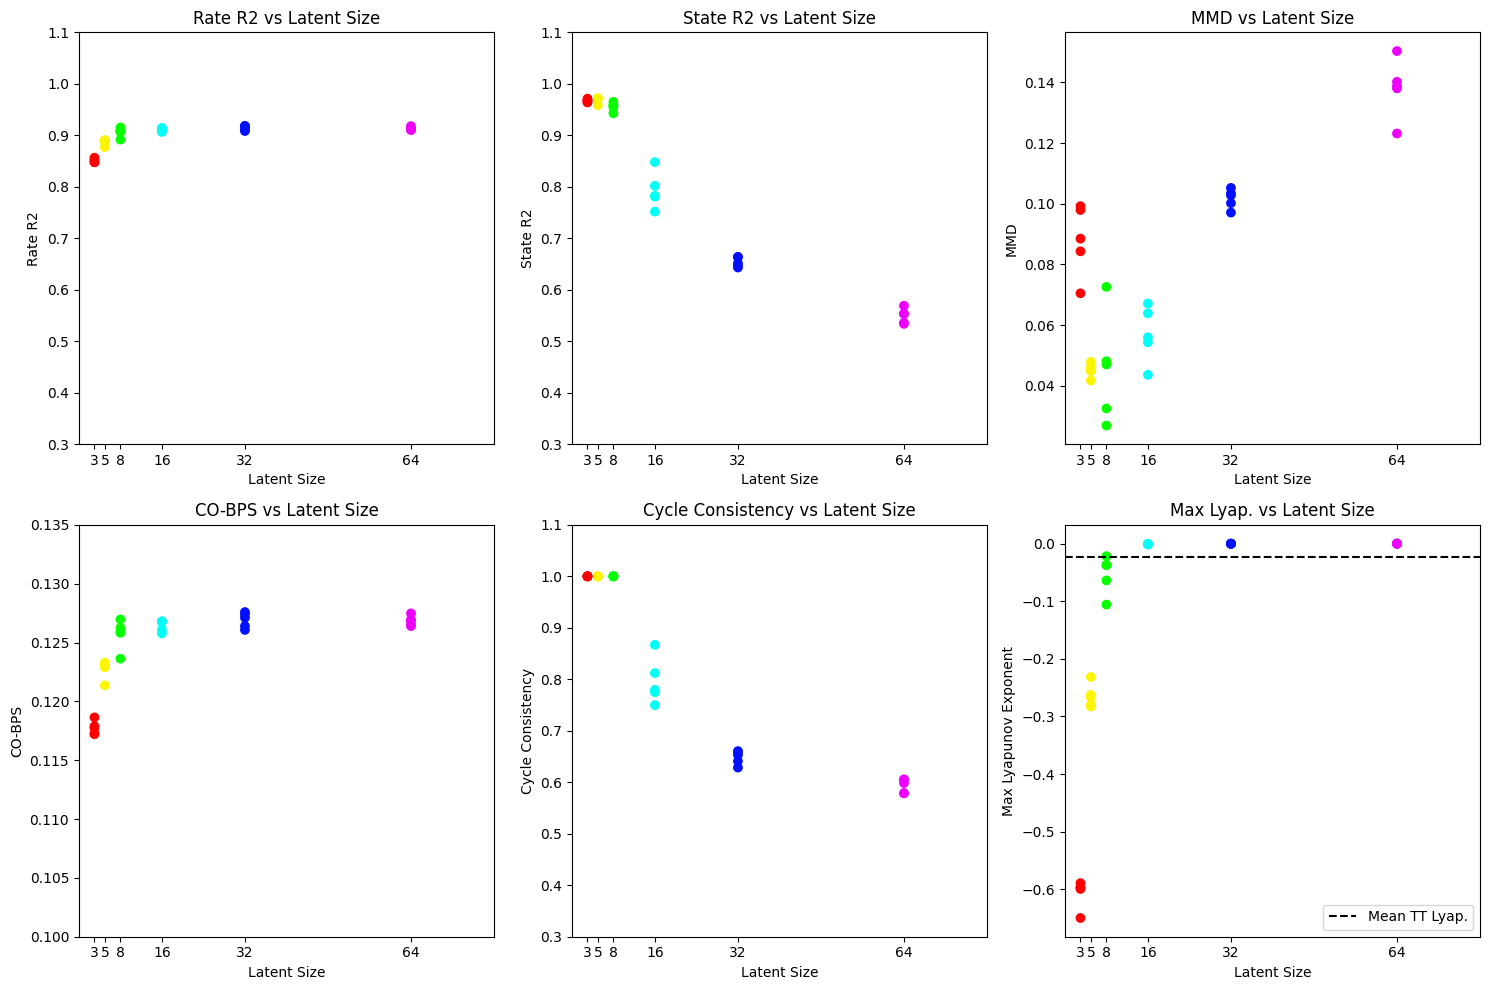

In [9]:
# Make a folder for the plots
if not os.path.exists("lat_size_plots"):
    os.makedirs("lat_size_plots")
lat_size = []
for group in groups:
    lat_size.append(int(group.split("NODE")[1].split("_")[0]))

u_lat_size, idx = np.unique(lat_size, return_index=True)
u_lat_size = u_lat_size[np.argsort(idx)]

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 3, 1)
ax.scatter(lat_size, metrics_s['rate_r2'], c = colors_list)
ax.set_xlabel("Latent Size")
ax.set_ylabel("Rate R2")
ax.set_xlim([0, 80])
ax.set_ylim([0.3, 1.1])
ax.set_title("Rate R2 vs Latent Size")
ax.set_xticks(u_lat_size)

ax = fig.add_subplot(2, 3, 2)
ax.scatter(lat_size, metrics_s['state_r2'], c = colors_list )
ax.set_xlabel("Latent Size")
ax.set_ylabel("State R2")
ax.set_xlim([0, 80])
ax.set_ylim([0.3, 1.1])
ax.set_xticks(u_lat_size)
ax.set_title("State R2 vs Latent Size")

ax = fig.add_subplot(2,3,3)
ax.scatter(lat_size, metrics_s['mmd'], c = colors_list)
ax.set_xlabel("Latent Size")
ax.set_ylabel("MMD")
ax.set_xlim([0, 80])
ax.set_title("MMD vs Latent Size")
ax.set_xticks(u_lat_size)

ax = fig.add_subplot(2,3,4)
ax.scatter(lat_size, metrics_s['co-bps'], c = colors_list)
ax.set_xlabel("Latent Size")
ax.set_ylabel("CO-BPS")
ax.set_xlim([0, 80])
ax.set_ylim([0.1, 0.135])
ax.set_title("CO-BPS vs Latent Size")
ax.set_xticks(u_lat_size)

ax = fig.add_subplot(2, 3, 5)
ax.scatter(lat_size, metrics_s['cycle_con'], c = colors_list)
ax.set_xlabel("Latent Size")
ax.set_ylabel("Cycle Consistency")
ax.set_xlim([0, 80])
ax.set_ylim([0.3, 1.1])
ax.set_title("Cycle Consistency vs Latent Size")
ax.set_xticks(u_lat_size)

lyaps = []
for ly in metrics_s['lyapunov']:
    lyaps.append(ly[0])
ax = fig.add_subplot(2,3,6)
ax.scatter(lat_size, lyaps, c = colors_list)
ax.axhline(lex_TT_mean[0].detach().numpy(), color='k', linestyle='--', label='Mean TT Lyap.')
ax.legend()
ax.set_xlabel("Latent Size")
ax.set_ylabel("Max Lyapunov Exponent")
ax.set_xlim([0, 80])
ax.set_title("Max Lyap. vs Latent Size")
ax.set_xticks(u_lat_size)
plt.tight_layout()
plt.savefig("lat_size_plots/NBFFCompiledVsLatentSize.pdf", dpi=300, bbox_inches='tight')


dict_keys(['val_r2', 'noise_stds', 'r2_per_noise', 'enc_state_dict', 'scalers'])
(30, 6)


/tmp/ipykernel_2589479/1286674072.py:40: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=colors1[np.where(unique_groups == legend_group)[0][0]], label=legend_group)


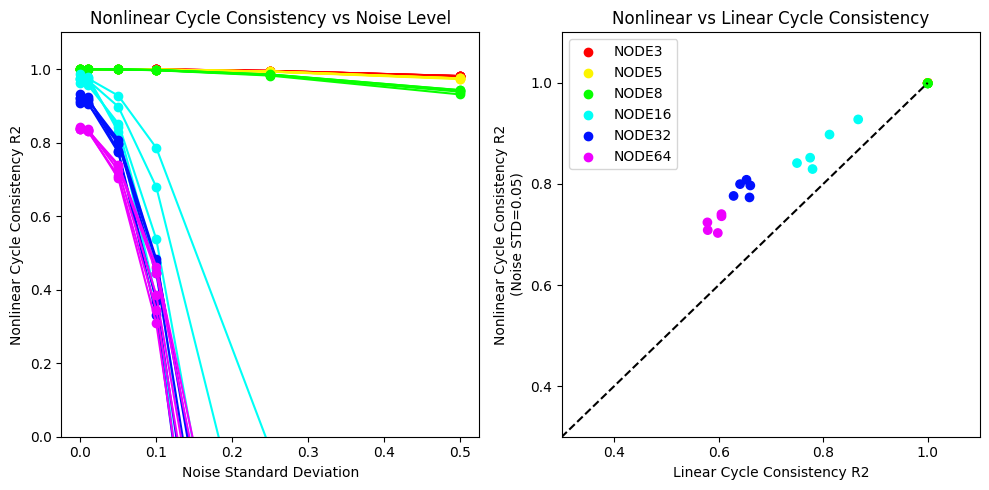

In [10]:
print(metrics['nl_cycle_con'][0].keys())
fig= plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
lat_size_included = []
nl_ccs = metrics_s['nl_cycle_con']
for i, nl_cc in enumerate(nl_ccs):
    if lat_size[i] in lat_size_included:
        label = None
    else:
        label = f"Latent Size {lat_size[i]}"
    lat_size_included.append(lat_size[i])
    noise_levels = nl_cc['noise_stds']
    r2_per_noise = nl_cc['r2_per_noise']
    ax.plot(noise_levels, r2_per_noise, marker='o', label=label, color=colors_list[i])
    # Make x axis log scale
# Print legend outside the plot
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim([0, 1.1])
ax.set_xlabel("Noise Standard Deviation")
ax.set_ylabel("Nonlinear Cycle Consistency R2")
ax.set_title("Nonlinear Cycle Consistency vs Noise Level")
# save as pdf

ax = fig.add_subplot(122)

nl_ccs = metrics_s['nl_cycle_con']
unique_noises = nl_ccs[0]['noise_stds']  # assume same noise_stds for all runs
num_noises = len(unique_noises)
noise_ind = 2

# Build an array: rows = latent sizes, cols = noise levels
all_r2 = np.array([cc['r2_per_noise'] for cc in nl_ccs])  # shape (n_latent_sizes, n_noise_levels)
print(all_r2.shape)
noise_level_r2 = all_r2[:, noise_ind]

ax.scatter(metrics_s['cycle_con'], noise_level_r2, c = colors_list)

# Add legend for latent sizes
for legend_group in unique_groups:
    ax.scatter([], [], c=colors1[np.where(unique_groups == legend_group)[0][0]], label=legend_group)

ax.legend()
# Plot unity line
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.3, 1.1])
ax.set_ylim([0.3, 1.1])
ax.set_xticks([0.4, 0.6, 0.8, 1.0])
ax.set_yticks([0.4, 0.6, 0.8, 1.0])
ax.set_xlabel("Linear Cycle Consistency R2")
ax.set_ylabel(f"Nonlinear Cycle Consistency R2\n(Noise STD={unique_noises[noise_ind]})")
ax.set_title("Nonlinear vs Linear Cycle Consistency")
plt.tight_layout()
plt.tight_layout()
plt.savefig("lat_size_plots/NLCCSuppFig.pdf", dpi=300, bbox_inches='tight')


In [11]:
fig = plt.figure(figsize=(5, 5))



<Figure size 500x500 with 0 Axes>